# Code for finding candidate exoplanets with periods >30 days + plotting light curves
(instead of searching database one by one)

note: we can change min period as needed

In [69]:
import os
# abbreviate beginning of line so window doesn't get stuck --> was error previously
os.environ['LIGHTKURVE_CACHE'] = "C:/lkcache"

import lightkurve as lk
from lightkurve import search_tesscut
from astropy.timeseries import BoxLeastSquares
from astroquery.mast import Catalogs
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
print("Lightkurve version:", lk.__version__)
print("Will probably have to run cell twice because warning shows the first time")

Lightkurve version: 2.5.1
Will probably have to run cell twice because warning shows the first time


# Code for finding TOIs with period >30 days
* Searching NASA Exoplanet Archive for TOIs with orbital periods >30 days
* Period range currently from 30 - 200, but we can change this as needed
* min_period/max_period in days (floats)
* min_sectors (integer)

In [70]:
# searching for long periods
def search_long_periods_tois(min_period=30, max_period=200, min_sectors=3):
    
    print("Searching NASA Exoplanet Archive for TOIs with orbital periods >30 days")
    print(f"Period range: {min_period} - {max_period} days")
    print(f"Minimum sectors: {min_sectors}")
    print("This may take awhile!\n")

    try:
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_rade, st_tmag",
            where=f"pl_orbper > {min_period} and pl_orbper < {max_period}"
        )
        
        df = toi_table.to_pandas()

        # clean up table
        df = df.dropna(subset=['tid', 'pl_orbper'])
        df["tic_id"] = df["tid"].astype(int)

        # sort periods (longest --> shortest) and brightness of star (brightest --> dimmest)
        df = df.sort_values(['pl_orbper', 'st_tmag'], ascending=[False, True])

# number of candidates (change as needed)
        num_candidates = 15    # change as needed
        
        print(f"Found {len(df)} TOIs with periods between {min_period} - {max_period} days")
        print(f"\nTop {num_candidates} candidates:")

        # display summary of TOIs and values
        display_columns = ['toi', 'tic_id', 'pl_orbper', 'pl_rade', 'st_tmag']
        summary = df[display_columns].head(num_candidates).copy()
        summary.columns = ['TOI', 'TIC_ID', 'Period(days)', 'Radius(Re)', 'Tmag']
                                  
        print(summary.to_string(index=False))
        return df
    
    except Exception as e:
        print(f"Error querying NASA Exoplanet Archive: {e}")

In [71]:
# call function
candidates_df = search_long_periods_tois(min_period=30, max_period=200)

Searching NASA Exoplanet Archive for TOIs with orbital periods >30 days
Period range: 30 - 200 days
Minimum sectors: 3
This may take awhile!

Found 226 TOIs with periods between 30 - 200 days

Top 15 candidates:
    TOI    TIC_ID  Period(days)  Radius(Re)     Tmag
 790.01 308994098    199.577907    6.993604  8.99140
1856.01 224313733    197.033625   12.071300 10.93740
4510.01 340458804    194.243286    4.471485 10.36070
 809.01 149301575    183.458919    3.379417 10.30460
4305.01 372068780    183.001911    5.593121  7.84590
2286.01 237201858    179.403171    3.747235  9.85236
2074.01 158075010    177.583051    3.595373  8.38689
2091.01 219778329    177.218887    2.032311  8.15290
5723.01 235901733    170.646515   12.850452 12.88570
7296.01 233735354    170.336391   11.691600 12.87710
2299.01 362220495    165.003158    4.517045  9.86300
6957.01  30853990    160.676021    3.216053 10.88650
2112.02 427320001    155.823700    5.552196  7.17760
 791.01 306472057    139.304851   10.466817 10

# Code for vetting (below) + print vetting results


# Guide to vetting
Good:
* possible exoplanet candidate
* check for U or V shape curve
* make sure odd.even transits math when plotted

Suspicious:
* check detection
* check for artifacts or stellar variability
* may need to check additional data

Bad:
* likely not an exoplanet
* probably an eclipse or instrumental artifact

In [76]:
def vet_detection(results):
    period = results['period']
    depth_ppm = results['depth_ppm']
    duration_hrs = results['duration'] * 24
    power = results['power']
    
    # assume GOOD to start
    verdict = "GOOD"
    reasons = []

    # red flag bad data
    if depth_ppm > 20000:  # > 2%
        verdict = "BAD"
        reasons.append(f"Depth too large ({depth_ppm:.0f} ppm = {depth_ppm/10000:.1f}%) - likely eclipsing binary")
    
    # check if period matches sector boundaries (27.4 day artifacts)
    sector_length = 27.4
    for mult in [1, 2, 3, 4, 5]:
        if abs(period - mult * sector_length) < 2.0:
            verdict = "BAD"
            reasons.append(f"Period matches {mult}× sector length ({mult*sector_length:.1f}d) - likely instrumental artifact")
            break
    
    if duration_hrs < 0.5:
        verdict = "BAD"
        reasons.append(f"Duration too short ({duration_hrs:.1f} hrs) - suspicious")
    
    if power < 100:
        verdict = "BAD"
        reasons.append(f"BLS power too low ({power:.0f}) - weak signal")

    # yellow flag data not already BAD
    if verdict != "BAD":
        if depth_ppm > 10000:  # 1-2%
            verdict = "SUSPICIOUS"
            reasons.append(f"Large depth ({depth_ppm:.0f} ppm) - could be giant planet or binary")
        
        if depth_ppm < 100:  # < 0.01%
            verdict = "SUSPICIOUS"
            reasons.append(f"Very shallow ({depth_ppm:.0f} ppm) - hard to confirm")
        
        if duration_hrs > 12:
            verdict = "SUSPICIOUS"
            reasons.append(f"Long duration ({duration_hrs:.1f} hrs) - unusual for planet")

    # green flag good data --> no flags = GOOD
    if len(reasons) == 0:
        reasons.append(f"Reasonable depth ({depth_ppm:.0f} ppm), duration ({duration_hrs:.1f} hrs), and period ({period:.1f}d)")
    
    return verdict, reasons

# print vetting results for each TIC
def print_vet_result(tic_id, results):
    verdict, reasons = vet_detection(results)
    if verdict == "GOOD":
        color_msg = "GOOD CANDIDATE"
    elif verdict == "SUSPICIOUS":
        color_msg = "SUSPICIOUS - REVIEW CAREFULLY"
    else:  # BAD
        color_msg = "LIKELY FALSE POSITIVE"
    
    print(f"\nTIC {tic_id}: {color_msg}")
    for reason in reasons:
        print(f"   → {reason}")

# Code for downloading TESS data, extracting/combining light curves, running BLS periodogram, creating plots and returning parameters
* note: this is similar code to IndividualExo notebook (just for all the candidate exoplanets)
* tic_id (integer/string)
* period_min/period_max (float)

In [77]:
def analyze_target(tic_id, period_min=1, period_max=120, plot=True):
    
    target = f"TIC {tic_id}"
    print(f"ANALYZING {target}")
    
    # download
    try:
        search = lk.search_tesscut(target)
        if len(search) == 0:
            print(f"No TESS data found")
            return None
        print(f"Found {len(search)} sectors")
        tpfs = search.download_all(cutout_size=5)
    except Exception as e:
        print(f"Error downloading: {e}")
        return None
    
    # extracting
    lc_list = []
    for tpf in tpfs:
        try:
            if tpf.flux.size == 0:
                continue
            
            # selecting aperture 
            mask = tpf.create_threshold_mask(threshold=3)
            if mask.sum() == 0:
                mask = tpf.create_threshold_mask(threshold=1)
            if mask.sum() == 0:
                mask = tpf.pipeline_mask
            
            lc = tpf.to_lightcurve(aperture_mask=mask)
            
            # removing bad quality data
            lc = lc[lc.quality == 0]  # Keep only highest quality data
            lc = lc.remove_nans()
            
            # removing outliers BEFORE flattening
            lc = lc.remove_outliers(sigma=5)
            
            if len(lc.time) < 500:
                continue
            
            # flattening
            lc = lc.flatten(window_length=301)
            
            # removing outliers (2nd time) after flattening
            lc = lc.remove_outliers(sigma=4)
            
            # clip extreme values bc indicate bad data
            flux_median = np.median(lc.flux.value)
            flux_std = np.std(lc.flux.value)
            
            # removing points more than 5-sigma from median
            mask_good = np.abs(lc.flux.value - flux_median) < 3 * flux_std
            lc = lc[mask_good]
            
            # final check: remove negative flux
            lc = lc[lc.flux.value > 0]
            
            if len(lc.time) < 500:
                print(f"  Sector {tpf.sector}: too few points after cleaning")
                continue
            
            lc_list.append(lc)
            print(f"Sector {tpf.sector}: {len(lc.time)} clean points")
            
        except Exception as e:
            print(f"Sector {tpf.sector}: {e}")
            continue
    
    if len(lc_list) == 0:
        print(f"No valid light curves")
        return None
    
    print(f"Extracted {len(lc_list)} light curves")
    
    # combining
    all_lc = lc_list[0]
    for lc in lc_list[1:]:
        all_lc = all_lc.append(lc)
    
    # normalize AFTER combining
    all_lc = all_lc.normalize()
    
    # DIAGNOSTIC: Check data quality
    print(f"\nData Quality Check:")
    print(f"  Flux median: {np.median(all_lc.flux.value):.4f}")
    print(f"  Flux std: {np.std(all_lc.flux.value):.4f}")
    print(f"  Min flux: {np.min(all_lc.flux.value):.4f}")
    print(f"  Max flux: {np.max(all_lc.flux.value):.4f}")
    print(f"  Negative flux? {np.any(all_lc.flux.value < 0)}")
    
    time_baseline = all_lc.time.value[-1] - all_lc.time.value[0]
    print(f"\nTime baseline: {time_baseline:.1f} days")
    print(f"Total data points: {len(all_lc.time)}")
    
    # run BLS
    print("\nRunning BLS search...")
    time = all_lc.time.value
    flux = all_lc.flux.value
    flux_error = all_lc.flux_err.value
    
    model = BoxLeastSquares(time, flux, flux_error)
    periods = np.linspace(period_min, period_max, 20000)
    durations = np.linspace(0.05, 0.4, 10)
    
    bls_result = model.power(periods, durations)
    
    # extract results
    best_index = np.argmax(bls_result.power)
    results = {
        'tic_id': tic_id,
        'period': bls_result.period[best_index],
        'duration': bls_result.duration[best_index],
        't0': bls_result.transit_time[best_index],
        'power': bls_result.power[best_index],
        'depth': bls_result.depth[best_index],
        'depth_ppm': bls_result.depth[best_index] * 1e6,
        'time_baseline': time_baseline,
        'n_points': len(time)
    }
    
    print(f"\nBLS Complete!")
    print(f"  Period: {results['period']:.4f} days")
    print(f"  Duration: {results['duration']*24:.2f} hours")
    print(f"  Depth: {results['depth_ppm']:.1f} ppm")
    print(f"  Power: {results['power']:.4f}")
    
    # plot results (this plot EVERYTHING)
    if plot:
        fig = plt.figure(figsize=(16, 10))
        
        # full light curve (for EACH TOI)
        ax1 = plt.subplot(3, 2, 1)
        all_lc.plot(ax=ax1)
        ax1.set_title(f"{target} - Full Light Curve", fontsize=12, fontweight='bold')
        
        # BLS periodogram
        ax2 = plt.subplot(3, 2, 2)
        ax2.plot(bls_result.period, bls_result.power, 'k-', lw=0.5, alpha=0.7)
        ax2.axvline(results['period'], color='red', linestyle='--', lw=2, 
                    label=f"P={results['period']:.3f}d")
        ax2.set_xlabel("Period (days)")
        ax2.set_ylabel("BLS Power")
        ax2.set_title("BLS Periodogram", fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)    
        
        # folded light curve (scatter)
        ax3 = plt.subplot(3, 2, 3)
        lc_fold = all_lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_fold.scatter(ax=ax3, s=2, alpha=0.3, c='black')
        ax3.set_title(f"Folded Light Curve (P={results['period']:.3f}d)", 
                     fontsize=12, fontweight='bold')
        ax3.set_xlabel("Phase")
        ax3.set_ylabel("Normalized Flux")
        ax3.grid(alpha=0.3)
        
        # folded light curve (binned)
        ax4 = plt.subplot(3, 2, 4)
        lc_fold_binned = lc_fold.bin(time_bin_size=0.01)
        lc_fold_binned.scatter(ax=ax4, s=20, c='red', alpha=0.8)
        ax4.set_title(f"Binned Folded (Depth={results['depth_ppm']:.1f}ppm)", 
                     fontsize=12, fontweight='bold')
        ax4.set_xlabel("Phase")
        ax4.set_ylabel("Normalized Flux")
        ax4.grid(alpha=0.3)

        # transit locations
        ax5 = plt.subplot(3, 2, (5, 6))
        n_transits = int(time_baseline / results['period'])
        transit_times = results['t0'] + results['period'] * np.arange(n_transits)
        ax5.plot(time, flux, 'k.', ms=2, alpha=0.5)
        for tt in transit_times:
            if time[0] <= tt <= time[-1]:
                ax5.axvline(tt, color='red', alpha=0.3, lw=1)
        ax5.set_xlabel("Time (BTJD)")
        ax5.set_ylabel("Normalized Flux")
        ax5.set_title(f"Light Curve with Predicted Transits (~{n_transits} expected)", 
                     fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    return results
        

# Code for analyzing top 10 candidates
* note: can change number of candidates as needed
* puts results of all TICs in summary table and saves to csv file for later


Analyze multiple targets TOIs and compile results
* tic_ids(list)
* period_min/period_max in days (float)

In [78]:
def batch_analyze(tic_ids, period_min=1, period_max=120, save_results=True):
    
    results_list = []
    
    print(f"Batch Analysis: {len(tic_ids)} TARGETS")
    
    for i, tic_id in enumerate(tic_ids, 1):
        print(f"\n[{i}/{len(tic_ids)}] Processing TIC {tic_id}...")
        
        result = analyze_target(tic_id, period_min, period_max, plot=False)
        
        if result is not None:
            # vet detection
            verdict, reasons = vet_detection(result)
            result['verdict'] = verdict  # add verdict to results
            results_list.append(result)
            print(f"  P={result['period']:.3f}d, Depth={result['depth_ppm']:.1f}ppm")
            
            # print vetting result
            print_vet_result(tic_id, result)
        else:
            print(f"  ✗ Failed to analyze TIC {tic_id}")
        

    # create summary dataframe
    if len(results_list) > 0:
        df_results = pd.DataFrame(results_list)
        df_results = df_results.sort_values('power', ascending=False)
        
        print("Finished Batch Analysis")
        print(f"\nSuccessfully analyzed {len(df_results)} targets:")

        # show results with vetting
        summary_cols = ['tic_id', 'period', 'depth_ppm', 'power', 'verdict']
        print(df_results[summary_cols].to_string(index=False))
        
        # summary of statistics
        n_good = (df_results['verdict'] == 'GOOD').sum()
        n_suspicious = (df_results['verdict'] == 'SUSPICIOUS').sum()
        n_bad = (df_results['verdict'] == 'BAD').sum()

        print(f"VETTING SUMMARY:")
        print(f"Good candidates: {n_good}")
        print(f"Suspicious: {n_suspicious}")
        print(f"Likely false positives: {n_bad}")
                
        if save_results:
            filename = "tess_bls_results.csv"
            df_results.to_csv(filename, index=False)
            print(f"\nResults saved to {filename}")
        
        return df_results
    else:
        print("No successful analyses")
        return None

# Example with TIC 279741379, TOI-186 (known long period candidate)
* I am just using this for testing the functions, ignore/delete later

Finding TESS Long-Period Exoplanet

Search TOI Database
Searching NASA Exoplanet Archive for TOIs with orbital periods >30 days
Period range: 30 - 200 days
Minimum sectors: 3
This may take awhile!

Found 226 TOIs with periods between 30 - 200 days

Top 15 candidates:
    TOI    TIC_ID  Period(days)  Radius(Re)     Tmag
 790.01 308994098    199.577907    6.993604  8.99140
1856.01 224313733    197.033625   12.071300 10.93740
4510.01 340458804    194.243286    4.471485 10.36070
 809.01 149301575    183.458919    3.379417 10.30460
4305.01 372068780    183.001911    5.593121  7.84590
2286.01 237201858    179.403171    3.747235  9.85236
2074.01 158075010    177.583051    3.595373  8.38689
2091.01 219778329    177.218887    2.032311  8.15290
5723.01 235901733    170.646515   12.850452 12.88570
7296.01 233735354    170.336391   11.691600 12.87710
2299.01 362220495    165.003158    4.517045  9.86300
6957.01  30853990    160.676021    3.216053 10.88650
2112.02 427320001    155.823700    5.552196

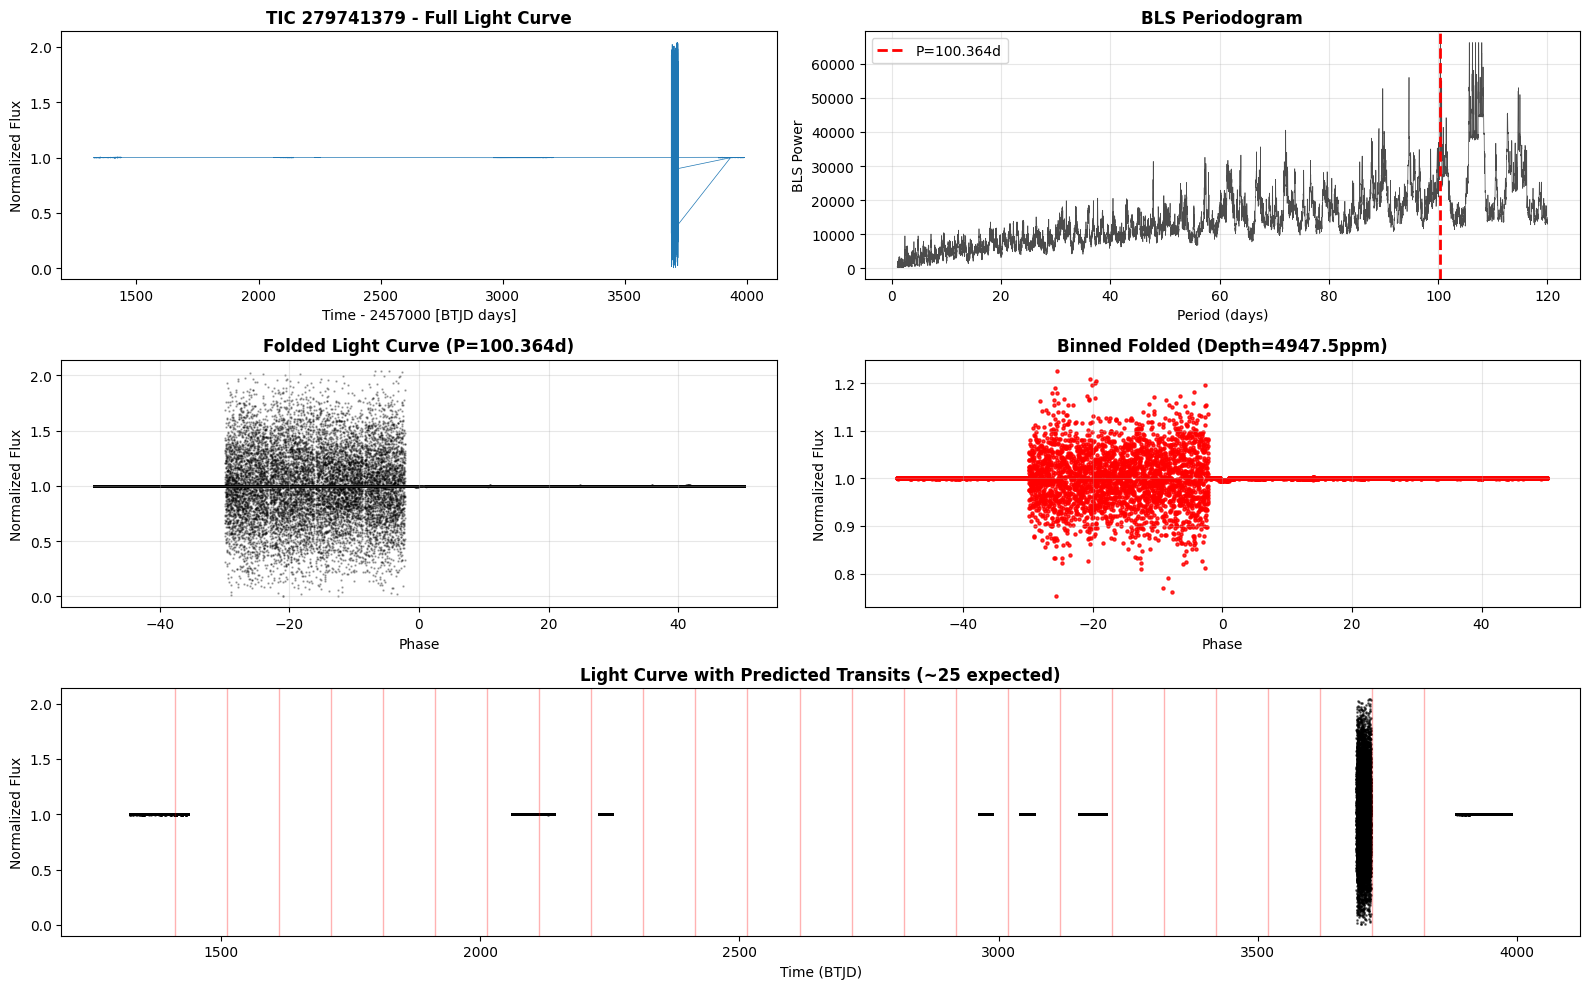



Batch Analysis
Using candidates from database search...
Batch Analysis: 10 TARGETS

[1/10] Processing TIC 308994098...
ANALYZING TIC 308994098
Found 24 sectors
Sector 4: 876 clean points
Sector 1: 1200 clean points
Sector 10: 974 clean points
Sector 11: 999 clean points
Sector 8: 819 clean points
Sector 9: 988 clean points
Sector 31: 3216 clean points
Sector 28: 3169 clean points
Sector 36: 2940 clean points
Sector 37: 3163 clean points
Sector 38: 3581 clean points
Sector 34: 3260 clean points
Sector 68: 10415 clean points
Sector 61: 9883 clean points
Sector 65: 6414 clean points
Sector 69: 8530 clean points
Sector 62: 9806 clean points
Sector 63: 10426 clean points
Sector 64: 10942 clean points
Sector 95: 8944 clean points
Sector 96: 9327 clean points
Sector 88: 10934 clean points
Sector 89: 11856 clean points
Sector 90: 11339 clean points
Extracted 24 light curves

Data Quality Check:
  Flux median: 1.0000
  Flux std: 1.5017
  Min flux: 0.0000
  Max flux: 29.7729
  Negative flux? F

Sector 16: 1023 clean points
Sector 23: 1156 clean points
Sector 50: 2897 clean points
Sector 77: 4501 clean points
Extracted 4 light curves

Data Quality Check:
  Flux median: 1.0000
  Flux std: 0.0011
  Min flux: 0.9935
  Max flux: 1.0066
  Negative flux? False

Time baseline: 1684.9 days
Total data points: 9577

Running BLS search...

BLS Complete!
  Period: 87.2004 days
  Duration: 9.60 hours
  Depth: 3487.8 ppm
  Power: 11307.7216
  P=87.200d, Depth=3487.8ppm

TIC 158075010: GOOD CANDIDATE
   → Reasonable depth (3488 ppm), duration (9.6 hrs), and period (87.2d)

[8/10] Processing TIC 219778329...
ANALYZING TIC 219778329
Found 43 sectors
Sector 16: 1044 clean points
Sector 15: 1128 clean points
Sector 17: 1008 clean points
Sector 14: 1188 clean points
Sector 18: 956 clean points
Sector 19: 1033 clean points
Sector 20: 1152 clean points
Sector 26: 1117 clean points
Sector 25: 1138 clean points
Sector 24: 654 clean points
Sector 23: 1137 clean points
Sector 21: 1209 clean points
Sect

In [79]:
if __name__ == "__main__":
    
    print("Finding TESS Long-Period Exoplanet")
    
    # Search for candidates in the database
    print("\nSearch TOI Database")
        # using same min and max period values as above
    candidates_df = search_long_periods_tois(min_period=30, max_period=200)
    
    # Analyze single target - TIC 279741379
    print("\n\nAnalyze Single Target")
    single_result = analyze_target(279741379, period_min=1, period_max=120)
    
    # Batch analyze top 10 candidates
    print("\n\nBatch Analysis")
    
    # Check if database search worked
    if candidates_df is not None:
        print("Using candidates from database search...")
        top_tics = candidates_df['tic_id'].head(10).tolist()
    else:
        print("Database search failed - using manual list of known candidates...")
        # Good long-period candidates to test
        top_tics = [279741379, 425997655, 52368076, 231663901, 393818]
    
    batch_results = batch_analyze(top_tics, period_min=20, period_max=150)